In [4]:
## *************** HELPFUL KAGGLE INFORMATION ******************

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
# Import packages!

import pandas as pd
import time
import random
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import scipy
import librosa
import os
from IPython.display import Audio
import shutil
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import seaborn as sns
from sklearn.model_selection import train_test_split

In [6]:
#Import file_path

#Both sex
RAVDESS_path ='/kaggle/input/speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/'

#Both Sex
Crema_path = '/kaggle/input/speech-emotion-recognition-en/Crema/'
crema_metadata_df = pd.read_csv('/kaggle/input/crema-metadata-extra-information/VideoDemographics.csv')

#Only male
SAVEE_path = '/kaggle/input/speech-emotion-recognition-en/Savee/' 

#Only female
TESS_path = '/kaggle/input/speech-emotion-recognition-en/Tess/'


In [7]:
#crema_metadata_df.loc[crema_metadata_df['Ethnicity'] == 'Hispanic']
crema_metadata_df.loc[crema_metadata_df['ActorID'] == 1013]

,ActorID,Age,Sex,Race,Ethnicity
12,1013,22,Female,Caucasian,Hispanic


In [8]:
def RAVDESS_extractor(audio_dir):
    data_list = []
    columns = ['Filename','Filepath','Gender','Emotion','Emotional Intensity']
    RAV_metadata_df = pd.DataFrame(columns = columns)
    
    # Map identifiers to their corresponding values
    emotion_dict = {
      "01": "neutral", "02": "neutral", "03": "happy", "04": "sad",
      "05": "angry", "06": "fear", "07": "disgust", "08": "surprised"
    }
    
    intensity_dict = {"01": "medium", "02": "high"}
    statement_dict = {"01": "Kids are talking by the door", "02": "Dogs are sitting by the door"}
    
    
    data_list = []
    for actor_folder in os.listdir(audio_dir):
      actor_path = os.path.join(audio_dir, actor_folder)
    
      if os.path.isdir(actor_path):  # Check if it's a folder
            for file in os.listdir(actor_path):
                if file.endswith(".wav"):
                    parts = file.split(".")[0].split("-") #first split the .wav extension then the '-'
    
                    # Extract metadata from the filename
                    modality = parts[0]  # Not used, as it’s audio-only for now
                    vocal_channel = "speech" if parts[1] == "01" else "song"
                    emotion = emotion_dict[parts[2]]
                    emotional_intensity = intensity_dict[parts[3]]
                    statement = statement_dict[parts[4]]
                    actor_id = int(parts[6])
                    gender = "male" if actor_id % 2 != 0 else "female"
                    file_path = os.path.join(actor_path, file)  # Full path to the file
                    
                    # Append to datalist (ignoring the repetition)
                    data_list.append({
                        'Filename': file,
                        'Filepath':file_path,
                        'Gender': gender,
                        'Emotion': emotion,
                        'Emotional Intensity': emotional_intensity
                    })
    
    df_addon = pd.DataFrame(data_list)
    RAV_metadata_df = pd.concat([RAV_metadata_df, df_addon], ignore_index=True)

    return RAV_metadata_df

def CREMA_extractor(audio_dir,crema_metadata_df):
    data_list = []
    emotion_map_dict = {'SAD':'sad',
                       'ANG':'angry',
                       'DIS':'disgust',
                       'FEA':'fear',
                       'HAP':'happy',
                       'NEU':'neutral'}
    intensity_dict = {'LO':'low',
                     'MD':'medium',
                     'HI':'high',
                     'XX':'unknown',
                     'X':'unknown'}

    columns = ['Filename','Filepath','Gender','Emotion','Emotional Intensity']
    crema_organized_df = pd.DataFrame(columns = columns)
    
    for file in os.listdir(audio_dir):
        parts = file.split('.')[0].split('_')

        file_name = file
        file_path = os.path.join(audio_dir,file)
        actor_id = int(parts[0])

        gender = crema_metadata_df.loc[crema_metadata_df['ActorID'] == actor_id]['Sex'].values[0].lower()
        emotion = emotion_map_dict[parts[2]]

        #debugging
        #print(file_name)
        intensity = intensity_dict[parts[3]]

        data_list.append({'Filename': file_name,
                         'Filepath':file_path,
                         'Gender':gender,
                         'Emotion':emotion,
                         'Emotional Intensity':intensity})

    df_addon = pd.DataFrame(data_list)
    crema_organized_df = pd.concat([crema_organized_df,df_addon],ignore_index=True)
    return crema_organized_df

def SAVEE_extractor(audio_dir):
    columns = ['Filename','Filepath','Gender','Emotion','Emotional Intensity']
    savee_metadata_df = pd.DataFrame(columns = columns)

    data_list = []
    
    emotion_map_dict = {'sa':'sad',
                       'a':'angry',
                       'd':'disgust',
                       'f':'fear',
                       'h':'happy',
                       'n':'neutral',
                        'su':'surprised'}

    for file in os.listdir(audio_dir):
        parts = file.split('.')[0].split('_')

        file_name = file
        file_path = os.path.join(audio_dir,file)
        gender = 'male'
        
        emotion_code = "".join([s for s in parts[1] if s.isalpha()])
        emotion = emotion_map_dict[emotion_code]
        intensity = 'unknown'

        data_list.append({'Filename': file_name,
                         'Filepath':file_path,
                         'Gender':gender,
                         'Emotion':emotion,
                         'Emotional Intensity':intensity})

    df_addon = pd.DataFrame(data_list)
    savee_metadata_df = pd.concat([savee_metadata_df,df_addon],ignore_index=True)
    return savee_metadata_df

def TESS_extractor(audio_dir):
    columns = ['Filename','Filepath','Gender','Emotion','Emotional Intensity']
    tess_metadata_df = pd.DataFrame(columns = columns)
    
    emotion_map_dict = {'sad':'sad',
                       'angry':'angry',
                       'disgust':'disgust',
                       'fear':'fear',
                       'happy':'happy',
                       'neutral':'neutral',
                       'ps':'surprised'}
    data_list = []
    
    for folder in os.listdir(audio_dir):
      folder_path = os.path.join(audio_dir, folder)
    
      if os.path.isdir(folder_path):  # Check if it's a folder
            for file in os.listdir(folder_path):
                if file.endswith(".wav"):
                    file_name = file
                    file_path = os.path.join(folder_path, file)
                    
                    parts = file.split('.')[0].split('_')
                    emotion = emotion_map_dict[parts[2].lower()]
                    intensity = 'unknown'
                    gender = 'female'
                    
                    data_list.append({'Filename': file_name,
                         'Filepath':file_path,
                         'Gender':gender,
                         'Emotion':emotion,
                         'Emotional Intensity':intensity})

    df_addon = pd.DataFrame(data_list)
    tess_metadata_df = pd.concat([tess_metadata_df,df_addon],ignore_index=True)
    return tess_metadata_df

In [9]:
# Get all the datasets metadata dataframe
ravdess_metadata_df = RAVDESS_extractor(RAVDESS_path)
crema_organized_df = CREMA_extractor(Crema_path,crema_metadata_df)
savee_metadata_df = SAVEE_extractor(SAVEE_path)
tess_metadata_df = TESS_extractor(TESS_path)


In [10]:
ravdess_metadata_df['Emotion'].unique()
crema_organized_df['Emotion'].unique()
savee_metadata_df['Emotion'].unique()
tess_metadata_df['Emotion'].unique()

array(['fear', 'angry', 'disgust', 'neutral', 'sad', 'surprised', 'happy'],
      dtype=object)

In [11]:
# Combine the metadata for all dataframes!

combined_metadata_df = pd.concat([ravdess_metadata_df,
                                  crema_organized_df,
                                  savee_metadata_df,
                                  tess_metadata_df])

combined_metadata_df.head()

,Filename,Filepath,Gender,Emotion,Emotional Intensity
0,03-01-08-01-01-01-02.wav,/kaggle/input/speech-emotion-recognition-en/Ra...,female,surprised,medium
1,03-01-01-01-01-01-02.wav,/kaggle/input/speech-emotion-recognition-en/Ra...,female,neutral,medium
2,03-01-07-02-01-02-02.wav,/kaggle/input/speech-emotion-recognition-en/Ra...,female,disgust,high
3,03-01-07-01-01-02-02.wav,/kaggle/input/speech-emotion-recognition-en/Ra...,female,disgust,medium
4,03-01-01-01-02-01-02.wav,/kaggle/input/speech-emotion-recognition-en/Ra...,female,neutral,medium


Emotion
disgust      1923
fear         1923
sad          1923
happy        1923
angry        1923
neutral      1895
surprised     652
Name: count, dtype: int64

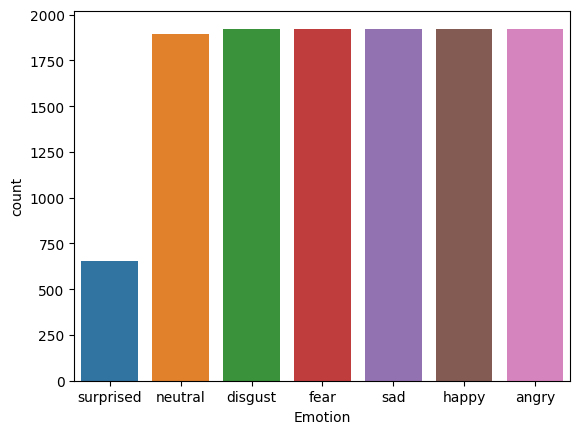

In [12]:
#Exploratory Data Analysis

sns.countplot(data = combined_metadata_df, x = 'Emotion')
combined_metadata_df['Emotion'].value_counts()


**Notice how surprise category is low on numbers! We should perform data augmentation only on the training dataset to avoid data leakage**

The game plan is to:
* 1: Augment data to the surprised category to make it balanced
* 2: Split the data into training and testing datasets
* 3: Augment the training dataset


In [13]:
#Surprised dataframe

surprised_df = combined_metadata_df.loc[combined_metadata_df['Emotion'] == 'surprised']


#Write Augmentation Functions and Helper Functions:
augmented_dir = "augmented_surprised_samples"

#Delete everyfile in augmented_dirs_folder
if os.path.exists(augmented_dir):
    shutil.rmtree(augmented_dir) 
os.makedirs(augmented_dir, exist_ok=True)


#set random seed to be 42
random.seed(42)

def add_white_noise(waveform, 
                    noise_level=np.random.uniform(low =  0.0001,high = 0.001)):
    noise = torch.randn_like(waveform) * noise_level
    return waveform + noise

def time_stretch(waveform, sample_rate, rate=None):
    if rate is None:
        rate = np.random.uniform(0.8, 1.2)
    waveform_np = waveform.squeeze().cpu().numpy()  # Convert to NumPy
    stretched = librosa.effects.time_stretch(waveform_np, rate=rate)
    return torch.tensor(stretched).unsqueeze(0)  # Convert back to tensor with channel dimension

def pitch_scale(waveform, sample_rate, 
                n_steps=None):
    if n_steps is None:
        n_steps = np.random.uniform(low = -1, high = 1)
    waveform_np = waveform.squeeze().cpu().numpy()  # Convert to NumPy
    pitched = librosa.effects.pitch_shift(waveform_np, sr=sample_rate, n_steps=n_steps)
    return torch.tensor(pitched).unsqueeze(0)  # Convert back to tensor with channel dimension

def polarity_inversion(waveform):
    return -waveform

def apply_gain(waveform, gain_factor = np.random.uniform(low = 5, high = 30)):
    gain = torchaudio.transforms.Vol(gain = gain_factor, gain_type = 'amplitude')
    return gain(waveform)

def apply_augmentations(waveform, sample_rate):
    # List of possible augmentations
    augmentations = [
        lambda x: add_white_noise(x),
        lambda x: time_stretch(x, sample_rate),
        lambda x: pitch_scale(x, sample_rate),
        lambda x: polarity_inversion(x),
        lambda x: apply_gain(x)
    ]
    
    # Randomly choose one or more augmentations to apply
    num_augmentations = 1
    selected_augmentations = random.sample(augmentations, num_augmentations)
    
#      # Check if both time_stretch and pitch_scale are in the selected augmentations
#     if any(aug in selected_augmentations for aug in [time_stretch, pitch_scale]):
#         # Filter out time_stretch and pitch_scale if both are in selected_augmentations
#         if time_stretch in selected_augmentations and pitch_scale in selected_augmentations:
#             # Randomly remove one of them
#             aug_to_remove = random.choice([time_stretch, pitch_scale])
#             selected_augmentations = [aug for aug in selected_augmentations if aug != aug_to_remove]
            
#             # Add a different augmentation that's not already in the list
#             remaining_augmentations = [
#                 aug for aug in augmentations if aug not in selected_augmentations and aug not in [time_stretch, pitch_scale]]
#             new_aug = random.choice(remaining_augmentations)
#             selected_augmentations.append(new_aug)
    
    for augment in selected_augmentations:
        waveform = augment(waveform)
    return waveform

# Assuming you have a dataframe 'surprised_df' with original "surprised" audio samples
def create_augmented_samples(surprised_df):
    augmented_samples = []
    
    for version in range(1,3):
        # First round of augmentation (AugmentedV1)
        for i, row in surprised_df.iterrows():
            file_path = row['Filepath']
            file_name = row['Filename'].split('.')[0]
            
            augmented_file_name = f"{file_name}_surprised_augmentedV{version}_{i}.wav"
            gender = row['Gender']
            emotional_intensity = row['Emotional Intensity']
            
            
            waveform, original_sr = torchaudio.load(file_path)
            print(file_name)

            # Ensure waveform is 2D [1, num_samples] if it's mono
            if waveform.ndim > 1:
                waveform = waveform.mean(dim = 0).unsqueeze(0)

            # Apply augmentations to create the first round of augmented samples
            augmented_waveform = apply_augmentations(waveform, original_sr)

            # Save augmented sample to a new file
            augmented_file_path = os.path.join(augmented_dir, augmented_file_name)
            torchaudio.save(augmented_file_path, augmented_waveform, original_sr, channels_first = True)

            # Append augmented sample details to the list
            augmented_samples.append({
                'Filename': augmented_file_name,
                'Filepath': augmented_file_path,
                'Gender': gender,
                'Emotion': 'surprised',  # Keep the same emotion label
                'Emotional Intensity': emotional_intensity,
                'Augmentation_Type': f'AugmentedV{version}'  # Tag the augmentation type
            })

    # Convert to DataFrame for compatibility
    augmented_df = pd.DataFrame(augmented_samples)
    return augmented_df
#Augment only the surprised_df to create new samples:
sample_rate = 24414 
augmented_surprised_df = create_augmented_samples(surprised_df) 


03-01-08-01-01-01-02
03-01-08-02-02-01-02
03-01-08-02-01-01-02
03-01-08-02-01-02-02
03-01-08-02-02-02-02
03-01-08-01-02-01-02
03-01-08-01-02-02-02
03-01-08-01-01-02-02
03-01-08-02-01-02-17
03-01-08-02-01-01-17
03-01-08-02-02-02-17
03-01-08-01-02-02-17
03-01-08-01-01-01-17
03-01-08-01-01-02-17
03-01-08-01-02-01-17
03-01-08-02-02-01-17
03-01-08-01-02-02-05
03-01-08-02-01-01-05
03-01-08-01-01-01-05
03-01-08-02-01-02-05
03-01-08-02-02-02-05
03-01-08-01-01-02-05
03-01-08-01-02-01-05
03-01-08-02-02-01-05
03-01-08-02-02-01-16
03-01-08-01-01-02-16
03-01-08-02-01-02-16
03-01-08-01-02-01-16
03-01-08-01-01-01-16
03-01-08-02-01-01-16
03-01-08-02-02-02-16
03-01-08-01-02-02-16
03-01-08-01-01-01-21
03-01-08-02-01-02-21
03-01-08-02-01-01-21
03-01-08-01-01-02-21
03-01-08-01-02-02-21
03-01-08-02-02-01-21
03-01-08-02-02-02-21
03-01-08-01-02-01-21
03-01-08-01-02-01-01
03-01-08-01-01-02-01
03-01-08-02-01-01-01
03-01-08-02-01-02-01
03-01-08-01-02-02-01
03-01-08-02-02-02-01
03-01-08-02-02-01-01
03-01-08-01-0

Emotion
surprised    1956
disgust      1923
fear         1923
sad          1923
happy        1923
angry        1923
neutral      1895
Name: count, dtype: int64

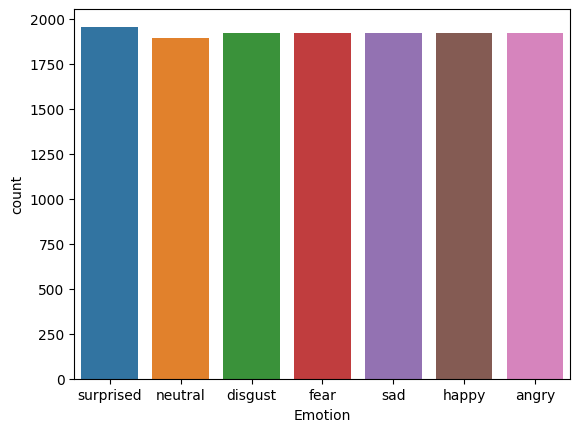

In [14]:
#Combine the augmented surprised with the combined_metadata_df 

combined_metadata_df = pd.concat((combined_metadata_df,
                                  augmented_surprised_df.drop('Augmentation_Type',axis = 1)))

sns.countplot(data = combined_metadata_df, x = 'Emotion')
combined_metadata_df['Emotion'].value_counts()

In [99]:
#Splitting Training and Testing Data

#gameplan:
#1. Take nonaugmented surprised samples and make those the testing samples
#2. Take the other emotions and create testing and training samples 

# Take nonaugmented surprised data for testing data


#Create function for creating training and testing indices for other emotions
def creating_training_testing_split(combined_metadata_df, test_size ,drop_emotion = True, **kwargs):

    """
    **kwargs can be the following:
    emotion_to_drop = emotion
    random_state = random_state for train_test_split

    """
    for key,value in kwargs.items():
        if key == 'emotion_to_drop':
            emotion_to_drop = value
        if key == 'random_state':
            random_state = value
            
    emotions_list = list(combined_metadata_df['Emotion'].unique())
    
    if drop_emotion == True:
        emotions_list.remove(emotion_to_drop)

    test_indices = {}
    train_indices = {}

    training_df = pd.DataFrame(columns = combined_metadata_df.columns)
    testing_df = pd.DataFrame(columns = combined_metadata_df.columns)

    for emotion in emotions_list:
        emotion_df = combined_metadata_df[combined_metadata_df['Emotion'] == emotion]
        test_size = 652

        train_idxs, test_idxs= train_test_split(range(len(emotion_df)), 
                                                 test_size = test_size, 
                                                 random_state = 42)
        #Append to dictionary  
        test_indices[emotion] =  test_idxs
        train_indices[emotion] =  train_idxs

        emotion_df_train = emotion_df.iloc[train_indices[emotion],:]
        emotion_df_test = emotion_df.iloc[test_indices[emotion],:]

        training_df = pd.concat((training_df,emotion_df_train),axis = 0)
        testing_df = pd.concat((testing_df,emotion_df_test),axis = 0)

    return training_df, testing_df, train_indices, test_indices

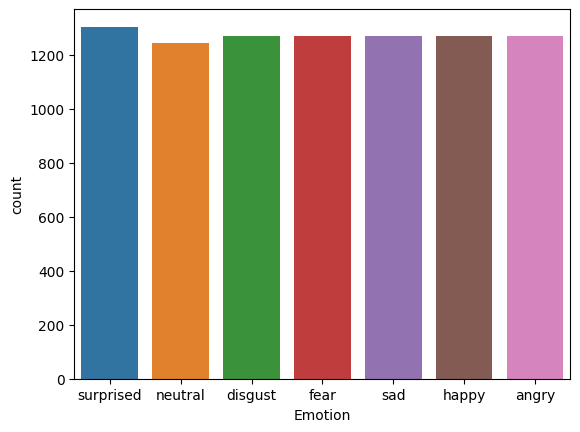

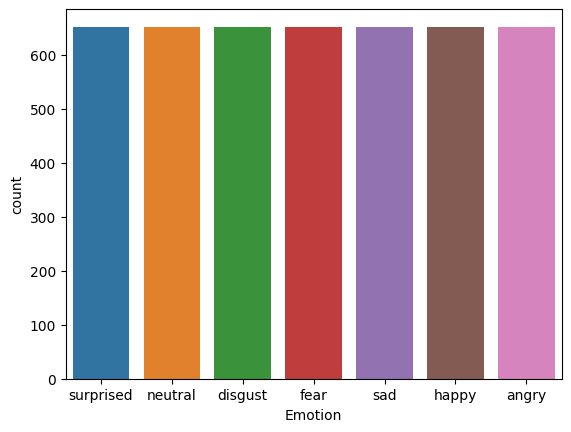

In [101]:
#Create the training splits by calling the function

surprised_df = combined_metadata_df.loc[combined_metadata_df['Emotion'] == 'surprised']

nonaugmented_surprised_df = []
augmented_surprised_df = []

for i,row in surprised_df.iterrows():
    
    gender = row['Gender']
    filename = row['Filename'] 
    filepath = row['Filepath']
    emotional_int = row['Emotional Intensity']
    emotion = row['Emotion']
    
    if 'surprised_augmented' not in row['Filename']:
        
        nonaugmented_surprised_df.append({
            'Filename': filename,
            'Filepath': filepath,
            'Gender': gender,
            'Emotion': emotion,
            'Emotional Intensity': emotional_int
        })
    else:
        augmented_surprised_df.append({
            'Filename': filename,
            'Filepath': filepath,
            'Gender': gender,
            'Emotion': emotion,
            'Emotional Intensity': emotional_int
        })
        
nonaugmented_surprised_df = pd.DataFrame(nonaugmented_surprised_df)
augmented_surprised_df = pd.DataFrame(augmented_surprised_df)
testing_samples = nonaugmented_surprised_df.shape[0]


training_df,testing_df,_,_ = creating_training_testing_split(combined_metadata_df, 
                                test_size = testing_samples ,
                                drop_emotion = True, 
                                emotion_to_drop = 'surprised')

#append the surprised to the training dataframes and testing dataframes
training_df = pd.concat((augmented_surprised_df,training_df),axis = 0)
testing_df = pd.concat((nonaugmented_surprised_df,testing_df),axis = 0)


training_df.shape

sns.countplot(data = training_df, x = 'Emotion')
combined_metadata_df['Emotion'].value_counts()
plt.show()

sns.countplot(data = testing_df, x = 'Emotion')
combined_metadata_df['Emotion'].value_counts()
plt.show()

In [ ]:
#We need to make sure the audio files are the same size when creating the dataloader:

#Helper functions:


def get_max_audio_length(metadata_df):
    """Calculate the maximum length of audio samples in the dataset."""
    start = time.time()
    max_length = 0
    for file_path in metadata_df['Filepath']:
        waveform, sample_rate = torchaudio.load(file_path)
        num_samples = waveform.shape[1]  # Number of samples in the waveform
        if num_samples > max_length:
            max_length = num_samples
    end = time.time()
    print (f'Max_length_found: {max_length}. Took {start - end} seconds')
    return max_length

def same_length_batch(batch):
    # Collate function to handle variable-length sequences

    # Extract waveforms, emotions, and genders from the batch
    waveforms = [item['waveform'].squeeze(0) for item in batch]  # Remove channel dimension if present (it's all mono anyways!)
    emotions = torch.stack([item['emotion'] for item in batch]) #example [0,1,2]
    genders = torch.stack([item['gender'] for item in batch]) #same as above
    intensity = torch.stack([item['intensity'] for item in batch])
    sample_rate = torch.stack([item['sample rate'] for item in batch])

    
    # Pad all waveforms to the same length (of the longest in the batch) ****THIS MEANS WE WILL HAVE TO MAKE THE NN VARIABLE LENGTH DEPENDING ON THE BATCH!
    waveforms_padded = pad_sequence(waveforms, batch_first=True) #put the batch dimension first!
    
    # Return padded waveforms and corresponding labels
    return {'waveform': waveforms_padded, 
            'emotion': emotions, 
            'gender': genders,
            'vocal channel': vocal_channels,
            'intensity':intensity,
            'statement': statement,
            'sample rate':sample_rate}

#Create the custom pytorch dataset

class Emotion_Classification_Dataset(Dataset):
    def __init__(self, metadata_df, transform=None, 
                 same_length_all = True, 
                 target_length = None,
                 target_sr = None,
                 augment_surprised=False):
        """
        Args:
            metadata_df (DataFrame): DataFrame containing file paths and labels.
            target_length (int): Target length for all audio samples in number of samples.
            transform (callable, optional): Optional transform to be applied on a sample (e.g., audio augmentation).
            same_length_all (Boolean): If True, enforce same length for all audio samples.
        """
        self.metadata_df = metadata_df
        self.transform = transform
        self.same_length_all = same_length_all #Boolean
        self.target_length = target_length
        self.augment_surprised = augment_surprised  # Boolean for augmenting "surprised" category
        self.target_sr = target_sr
        
    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        # Get file path and labels from the DataFrame
        file_path = self.metadata_df.iloc[idx]['Filepath']
        emotion_label = self.metadata_df.iloc[idx]['Emotion']
        gender_label = self.metadata_df.iloc[idx]['Gender']
        intensity = self.metadata_df.iloc[idx]['Emotional Intensity']
        
        # Load audio file (torchaudio returns waveform and sample rate)
        waveform, sample_rate = torchaudio.load(file_path)
        
        #Resample the data
        waveform = self.resample_if_necessary(waveform, sample_rate) 
            
        if self.same_length_all and self.target_length is not None:
            waveform = self.pad_or_trim_waveform(waveform, self.target_length)

        # Apply any optional transformation
        if self.transform:
            waveform = self.transform(waveform)
            




        # Convert labels to tensors or numerical values
        emotion_mapping = {
            "neutral": 0, "happy": 1, "sad": 2, "angry": 3,
            "fear": 4, "disgust": 5, "surprised": 6
        }
        gender_mapping = {"male": 0, "female": 1}
        intensity_mapping = {"low": 0, "medium": 1, "high": 2, "unknown": 3}

        emotion_tensor = torch.tensor(emotion_mapping[emotion_label])
        gender_tensor = torch.tensor(gender_mapping[gender_label])
        intensity_tensor = torch.tensor(intensity_mapping[intensity])
        # You can return the labels as part of a dictionary
        sample = {'waveform': waveform, 
                  'emotion': emotion_tensor, 
                  'gender': gender_tensor,
                  'intensity': intensity_tensor,
                  'sample rate':torch.tensor(sample_rate)}
        
        return sample
    
    def pad_or_trim_waveform(self, waveform, target_length):
        """Pad or trim waveform to a fixed target length in samples."""
        num_samples = waveform.shape[1]  # waveform shape is (channels, num_samples)

        if num_samples < target_length:
            # Pad if the waveform is shorter than target length
            padding = target_length - num_samples
            waveform = F.pad(waveform, (0, padding)) #pad the left with 0 0s and pad the right with padding amount of 0s
        elif num_samples > target_length:
            # Trim if the waveform is longer than target length
            waveform = waveform[:, :target_length]

        return waveform
    
    def resample_if_necessary(self, waveform, sr):
        if sr != self.target_sr:
            resampler = torchaudio.transforms.Resample(sr, self.target_sr)
            waveform = resampler(waveform) 
            
        return waveform


#not in the dataloader class btw....
def load_dataset(same_length_all = True,
                 sample_rate = 24414,
                 seconds_of_audio = 3):
    
    if same_length_all:
        
        #max length of our audio dataset (without any augmentation is 314818) 
        #max_length = get_max_audio_length(combined_metadata_df)
        #max_length = 314818 #TRUE MAX LENGTH
        max_length = sample_rate * seconds_of_audio
        ravdess_dataset = Emotion_Classification_Dataset(metadata_df=combined_metadata_df,
                                                transform = None,
                                                same_length_all = True,
                                                target_length = max_length,
                                                target_sr = 24414)
        dataloader = DataLoader(ravdess_dataset, 
                                batch_size=16, 
                                shuffle=True,  
                                num_workers = 4,
                                persistent_workers=True)
        
    else:
        ravdess_dataset = Emotion_Classification_Dataset(metadata_df=combined_metadata_df,
                                                transform = None,
                                                same_length_all = False,
                                                target_sr = 24414)
        dataloader = DataLoader(ravdess_dataset, 
                                batch_size=16, 
                                shuffle=True, 
                                collate_fn=same_length_batch, 
                                num_workers = 4,
                                persistent_workers=True)
    return dataloader


In [ ]:
torch.manual_seed(0)
start = time.time()
dataloader = load_dataset(same_length_all=True, seconds_of_audio = 3) #This takes around 4-5 min
end = time.time()

print(end - start)
# Iterate over the DataLoader (Print one iteration of the batch!)
for batch in dataloader:
    waveforms = batch['waveform']
    emotions = batch['emotion']
    genders = batch['gender']
    sample_rate = batch['sample rate']
    intensity = batch['intensity']
    print(waveforms.shape, emotions, genders,intensity,sample_rate)
    break

In [ ]:
#Play audio file
Audio(batch['waveform'][5].squeeze(), rate = 24414)